In [1]:
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot
import seaborn as sns


In [2]:
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import rbf_kernel

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
print(tf.__version__)
tf.config.list_physical_devices()

2.8.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def getLayerOutput(model, data, layer_idx = -1, softmaxed = True):

	"""
	Description
	---------------
	Retrieves the output of a given layer of a model over a given dataset

	Input(s)
	---------------
	model: The keras model to infere on.
	data: The dataset or datasample to infere with.
	layer_idx : Layer index to extract the output from, defaults to the last layer.
	"""
	
	if softmaxed:
		retriever = K.function([model.layers[0].input],[model.layers[layer_idx].output])
	else :
		output = [tf.keras.activations.softmax(model.layers[layer_idx].output)]
		retriever = K.function([model.layers[0].input],output)
	return retriever([data])[0]

In [6]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff 
    corr_coeff = np.dot(A_mA, B_mB.T) / ( np.sqrt(np.dot(ssA[:, None],ssB[None]) ) + 0.00001 )
    return corr_coeff
    

In [7]:
def pOrderTaylor(corr_matrix, order = 1):
    y = np.zeros(len(corr_matrix))
    for n, row in zip(range(order), corr_matrix):
        y = y + ((-1)**n * (row)**(2*n+1)) / np.math.factorial(2*n+1)
    return y

In [8]:
def corrCongruence(teacher_preds, student_preds, gamma = None, order = 2):
    rbf_student = rbf_kernel(student_preds,gamma=gamma)
    rbf_teacher = rbf_kernel(teacher_preds,gamma=gamma)
    taylored_student = pOrderTaylor(rbf_student, order=order)
    taylored_teacher = pOrderTaylor(rbf_teacher, order=order)
    congruence = sum(abs(taylored_teacher - taylored_student))
    return congruence

In [9]:
class RKD():
	def __init__(
		self,
		teacher: tf.keras.Model,
		student: tf.keras.Model,
		alreadySoftmax: bool = True,
		optimizer: tf.keras.optimizers = tf.keras.optimizers.Adam(),
		studentLoss: tf.keras.losses = tf.keras.losses.CategoricalCrossentropy(),
		distilLoss: tf.keras.losses = tf.keras.losses.KLDivergence(),
		metrics = [tf.keras.metrics.CategoricalAccuracy()]
	):
		"""
		Description
		---------------
		Initialize the teacher model, the student model and their last layer index.

		Input(s)
		---------------
		teacher: A trained Keras Sequential or Functional model (Sub-class models are not supported).
		student: An untrained Keras Sequential or Functional model (Sub-class models are not supported).
		alreadySoftmax : If the last layer is softmax it must be true, else it must be false (for teacher and student). By default true.
		optimizer: Optimizer instance. By default Adam.
		distilLoss: Loss instance. By default KLDivergence.
		metrics: List of metrics to be evaluated by the model during training and testing. By default accuracy.
		"""
		self.teacher = teacher
		self.student = student
		self.alreadySoftmax = alreadySoftmax
		self.metrics = metrics
		self.optimizer = optimizer
		self.distilLoss = distilLoss
		self.studentLoss = studentLoss

	def distil(
		self,
		trainData: tf.data.Dataset,
		valData: tf.data.Dataset,
		epochs: int = 1,
		trainBatchSize: int = None,
		valBatchSize: int = None,
		alpha: float = 0.1,
		beta: float = 0.5,
		gamma: int = None,
		order: int = 2,
		temperature: int = 3,
		history: bool = False
	):
		"""
		Description
		---------------
		Distil the knowledge of the teacher to the student.

		Input(s)
		---------------
		trainData: TensorFlow Dataset with training images.
		valData: TensorFlow Dataset with validation images.
		epochs: Number of epochs to distil the model. By default 1.
		trainBatchSize: Number of samples per gradient update. If None, we assume that the user provides a batched TensorFlow Dataset. By default None.
		valBatchSize: Number of samples per validation batch. If None, we assume that the user provides a batched TensorFlow Dataset. By default None.
		alpha: Loss weighting factor. By default 0.1.
		beta: Correlation congruence weighting factor. By default 0.5.
		temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions. By default 3.
		history: Boolean. If True, returns the losses and metrics history. If False, does not return history. By default False.

		Output(s)
		---------------
		distilled_model: Distilled Keras Sequential or Functional student model.
		"""
		# Compiling student model
		self.student.compile(
			optimizer=self.optimizer,
			loss=self.studentLoss,
			metrics=self.metrics
		)
		# Prepare the training dataset
		if trainBatchSize != None:
			trainData = trainData.shuffle(1024).batch(batch_size=trainBatchSize,drop_remainder=True)
		batchNbTrain = trainData.cardinality().numpy()
		# Prepare the validation dataset
		if valBatchSize != None:
			valData = valData.batch(batch_size=valBatchSize,drop_remainder=True)
		batchNbVal = valData.cardinality().numpy()
		# Getting metrics
		lossesAndMetrics = {}
		metricsHandlerTruth = []
		metricsHandlerTeacher = []
		for metric in self.metrics:
			metricsHandlerTruth.append(tf.keras.metrics.get(metric))
			metricsHandlerTeacher.append(tf.keras.metrics.get(metric))
		# Training
		for epoch in range(epochs):
			print("Distillation Epoch {}/{}".format(epoch+1, epochs))
			pb_train = tf.keras.utils.Progbar(batchNbTrain)
			for step, (x_batch_train, y_batch_train) in enumerate(trainData):
				# Teacher's forward pass
				teacherPredsTrain = self.teacher(x_batch_train, training=False)
				with tf.GradientTape() as tape:
					# Student's forward pass
					studentPredsTrain = self.student(x_batch_train, training=True)
					# Computing distillation/student losses and correlation congruence
					if self.alreadySoftmax == False:
						softMaxedTeacherPredsTrain = tf.keras.activations.softmax(teacherPredsTrain)
						softMaxedStudentPredsTrain = tf.keras.activations.softmax(studentPredsTrain)
						distilLossTrain = self.distilLoss(
							 softMaxedTeacherPredsTrain / temperature,
							 softMaxedStudentPredsTrain / temperature
						)
						studentLossTrain = self.studentLoss(
							y_batch_train,
							softMaxedStudentPredsTrain
						)
						correlation_congruence = corrCongruence(
							tf.keras.activations.softmax(teacherPredsTrain),
							tf.keras.activations.softmax(studentPredsTrain),
							gamma=gamma,
							order=order
						)
						
					else:
						distilLossTrain = self.distilLoss(
							teacherPredsTrain / temperature,
							studentPredsTrain / temperature
						)
						studentLossTrain = self.studentLoss(
							y_batch_train,
							tf.keras.activations.softmax(studentPredsTrain)
						)
						correlation_congruence = corrCongruence(
							teacherPredsTrain,
							studentPredsTrain,
							gamma=gamma,
							order=order
						)
					# Computing loss
					lossTrain = (alpha * studentLossTrain) + ((1 - alpha) * distilLossTrain) + (beta * correlation_congruence )
				# Computing metrics
				metricsTuplesTrain = []
				# Comparing to ground truth values
				for handler in metricsHandlerTruth:
					if step == 0:
						handler.reset_state()
					handler.update_state(y_batch_train.numpy(), studentPredsTrain.numpy())
					metricsTuplesTrain.append((handler.name, handler.result().numpy()))
				# Comparing to teacher
				for handler in metricsHandlerTeacher:
					if step == 0:
						handler.reset_state()
					handler.update_state(teacherPredsTrain.numpy(), studentPredsTrain.numpy())
					metricsTuplesTrain.append(("Distillation_" + handler.name, handler.result().numpy()))
				# Updating progress bar losses and metrics
				lossesTuplesTrain = [
					('Loss', lossTrain),
					('DistilLoss', distilLossTrain),
					('StudentLoss', studentLossTrain),
					('Correlation Congruence', correlation_congruence)
				]
				globalTuplesTrain = lossesTuplesTrain + metricsTuplesTrain
				pb_train.add(1, values=globalTuplesTrain)
				# Computing gradient
				gradients = tape.gradient(lossTrain, self.student.trainable_variables)
				# Update weights
				self.student.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
			# Adding training losses and metrics values to the model
			if epoch == 0:
				lossesAndMetrics['Loss'] = []
				lossesAndMetrics['DistilLoss'] = []
				lossesAndMetrics['StudentLoss'] = []
				lossesAndMetrics['Correlation Congruence'] = []
			lossesAndMetrics['Loss'].append(lossTrain.numpy())
			lossesAndMetrics['DistilLoss'].append(distilLossTrain.numpy())
			lossesAndMetrics['StudentLoss'].append(studentLossTrain.numpy())
			lossesAndMetrics['Correlation Congruence'].append(correlation_congruence)
			for handler in metricsHandlerTruth:
				if epoch == 0:
					lossesAndMetrics[handler.name] = []
				lossesAndMetrics[handler.name].append(handler.result().numpy())
			for handler in metricsHandlerTeacher:
				if epoch == 0:
					lossesAndMetrics["Distillation_" + handler.name] = []
				lossesAndMetrics["Distillation_" + handler.name].append(handler.result().numpy())
			# Validation
			pb_val = tf.keras.utils.Progbar(batchNbVal)
			for step, (x_batch_val, y_batch_val) in enumerate(valData):
				teacherPredsVal = self.teacher(x_batch_val, training=False)
				studentPredsVal = self.student(x_batch_val, training=False)
				# Computing losses and metrics
				# Computing losses
				if self.alreadySoftmax == False:
					distilLossVal = self.distilLoss(
						tf.keras.activations.softmax(teacherPredsVal) / temperature,
						tf.keras.activations.softmax(studentPredsVal) / temperature
					)
					studentLossVal = self.studentLoss(
						y_batch_val,
						tf.keras.activations.softmax(studentPredsVal)
					)
					correlation_congruence_val = corrCongruence(
							tf.keras.activations.softmax(teacherPredsVal),
							tf.keras.activations.softmax(studentPredsVal),
							gamma=gamma,
							order=order
					)

				else:
					distilLossVal = self.distilLoss(
						teacherPredsVal / temperature,
						studentPredsVal / temperature
					)
					studentLossVal = self.studentLoss(
						y_batch_val,
						tf.keras.activations.softmax(studentPredsVal)
					)
					correlation_congruence_val = corrCongruence(
							teacherPredsVal,
							studentPredsVal,
							gamma=gamma,
							order=order
					)
				lossVal = (alpha * studentLossVal) + ((1 - alpha) * distilLossVal)+ (beta * correlation_congruence_val )
				# Updating validation losses and metrics
				lossesTuplesVal = [
					('Val_loss', lossVal),
					('Val_distilLoss', distilLossVal),
					('Val_studentLoss', studentLossVal),
					('Val_Correlation Congruence', correlation_congruence_val)
				]
				# Computing metrics
				metricsTuplesVal = []
				# Comparing to ground truth values
				for handler in metricsHandlerTruth:
					if step == 0:
						handler.reset_state()
					handler.update_state(y_batch_val.numpy(), studentPredsVal.numpy())
					metricsTuplesVal.append(('Val_' + handler.name, handler.result().numpy()))
				# Comparing to teacher
				for handler in metricsHandlerTeacher:
					if step == 0:
						handler.reset_state()
					handler.update_state(teacherPredsVal.numpy(), studentPredsVal.numpy())
					metricsTuplesVal.append(("Val_distillation_" + handler.name, handler.result().numpy()))
				globalTuplesVal = lossesTuplesVal + metricsTuplesVal
				pb_val.add(1, values=globalTuplesVal)
			# Adding validation losses and metrics values to the model
			if epoch == 0:
				lossesAndMetrics['Val_loss'] = []
				lossesAndMetrics['Val_distilLoss'] = []
				lossesAndMetrics['Val_studentLoss'] = []
				lossesAndMetrics['Val_Correlation Congruence'] = []
			lossesAndMetrics['Val_loss'].append(lossVal.numpy())
			lossesAndMetrics['Val_distilLoss'].append(distilLossVal.numpy())
			lossesAndMetrics['Val_studentLoss'].append(studentLossVal.numpy())
			lossesAndMetrics['Val_Correlation Congruence'].append(correlation_congruence_val)
			for handler in metricsHandlerTruth:
				if epoch == 0:
					lossesAndMetrics["Val_" + handler.name] = []
				lossesAndMetrics["Val_" + handler.name].append(handler.result().numpy())
			for handler in metricsHandlerTeacher:
				if epoch == 0:
					lossesAndMetrics["Val_distillation_" + handler.name] = []
				lossesAndMetrics["Val_distillation_" + handler.name].append(handler.result().numpy())
		# Returning distilled student
		if history == True:
			return self.student, lossesAndMetrics
		else:
			return self.student

In [10]:
# plot diagnostic learning curves
def summarizeDiagnostics(history,evaluation):
	# plot accuracy
	pyplot.subplot(211)
	pyplot.title('Sparse Categorical Accuracy')
	pyplot.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='test')
	pyplot.axhline(evaluation['sparse_categorical_accuracy'] , color='red', ls='dotted', label='evaluation')
	pyplot.legend(['Train','Test','Evaluation'], loc= 'upper left')
	# plot loss
	pyplot.subplot(212)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.axhline(evaluation['loss'] , color='red', ls='dotted', label='evaluation')
	pyplot.tight_layout()
	

In [11]:
def distilAccuracies(history):
	# plot accuracies
	pyplot.title('Categorical Accuracy')
	pyplot.plot(history['categorical_accuracy'], color='blue', label='train')
	pyplot.plot(history['Val_categorical_accuracy'], color='orange', label='test')
	pyplot.axhline(history['Val_categorical_accuracy'][-1] , color='red', ls='dotted', label='evaluation')
	pyplot.legend(['Train','Test','Evaluation'], loc= 'upper left')

In [12]:
def distilLosses(history):
	# plot training losses
	pyplot.subplot(211)
	pyplot.title('Training Losses')
	pyplot.plot(history['Loss'], color='blue', label='loss')
	pyplot.plot(history['DistilLoss'], color='red', label='distillation')
	pyplot.plot(history['StudentLoss'], color='orange', label='student')
	pyplot.plot(history['Correlation Congruence'], color='green', label='correlation')
	pyplot.axhline(history['Loss'][-1] , color='red', ls='dotted', label='converged')
	pyplot.legend(['Loss','Distillation','Student','Correlation','Converged'], loc= 'upper left')
	# plot validation losses
	pyplot.subplot(212)
	pyplot.title('Validation Losses')
	pyplot.plot(history['Val_loss'], color='blue', label='v_loss')
	pyplot.plot(history['Val_distilLoss'], color='red', label='v_distillation')
	pyplot.plot(history['Val_studentLoss'], color='orange', label='v_student')
	pyplot.plot(history['Val_Correlation Congruence'], color='green', label='v_correlation')
	pyplot.axhline(history['Val_loss'][-1] , color='red', ls='dotted', label='v_converged')
	

	pyplot.tight_layout()

In [13]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        layers.Dropout(0.3),
        layers.Dense(10),
    ],
    name="teacher",
)
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                           

In [14]:
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Dropout(0.2),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
        layers.Dropout(0.2),
        layers.Dense(10),
    ],
    name="student",
)
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0   

In [15]:
# Clone student for later comparison
student_scratch = keras.models.clone_model(student)


In [42]:
# Clone student for later comparison
regular_distilled = keras.models.clone_model(student)

In [16]:
# Prepare the train and test dataset.
batch_size = 32
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 32, 32, 3))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 32, 32, 3))



In [17]:
nb_epochs = 50
top_k = 3

In [18]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.TopKCategoricalAccuracy(k=top_k)],
)


# Train and evaluate teacher on data.
teacher_history = teacher.fit(x_train, y_train, epochs= nb_epochs, validation_data=(x_test,y_test))
teacher_evaluation = teacher.evaluate(x_test, y_test, return_dict=True)


Epoch 1/50
1563/1563 [==============================] - 28s 17ms/step - loss: 1.8697 - sparse_categorical_accuracy: 0.3472 - top_k_categorical_accuracy: 0.3058 - val_loss: 1.5130 - val_sparse_categorical_accuracy: 0.4517 - val_top_k_categorical_accuracy: 0.2658
Epoch 2/50
1563/1563 [==============================] - 26s 17ms/step - loss: 1.4160 - sparse_categorical_accuracy: 0.4869 - top_k_categorical_accuracy: 0.3046 - val_loss: 1.2441 - val_sparse_categorical_accuracy: 0.5502 - val_top_k_categorical_accuracy: 0.3306
Epoch 3/50
1563/1563 [==============================] - 26s 17ms/step - loss: 1.2226 - sparse_categorical_accuracy: 0.5593 - top_k_categorical_accuracy: 0.3315 - val_loss: 1.0865 - val_sparse_categorical_accuracy: 0.6152 - val_top_k_categorical_accuracy: 0.3562
Epoch 4/50
1563/1563 [==============================] - 26s 17ms/step - loss: 1.0852 - sparse_categorical_accuracy: 0.6143 - top_k_categorical_accuracy: 0.3363 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 

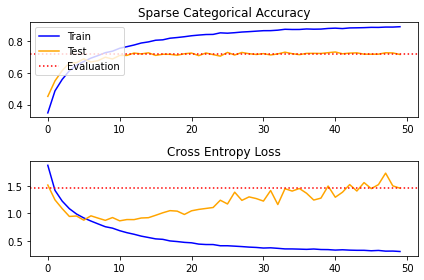

In [19]:
summarizeDiagnostics(teacher_history,teacher_evaluation)

In [20]:
dist = RKD(
		teacher,
		student,
		alreadySoftmax=False,
		optimizer=tf.keras.optimizers.Adam(),
		studentLoss=tf.keras.losses.CategoricalCrossentropy(),
		metrics = [tf.keras.metrics.CategoricalAccuracy()]
	)

In [21]:
y_cat_train =  tf.keras.utils.to_categorical(y_train, num_classes=10)
y_cat_test =  tf.keras.utils.to_categorical(y_test, num_classes=10)

In [22]:
train_sparse = tf.data.Dataset.from_tensor_slices((x_train, y_cat_train))
test_sparse = tf.data.Dataset.from_tensor_slices((x_test, y_cat_test))

In [23]:
distilled, d_history = dist.distil(
    trainData=train_sparse,
    valData=test_sparse,
    alpha = 0.1,
    temperature = 7,
    beta = 0.3,
    epochs=nb_epochs,
    trainBatchSize=batch_size,
    valBatchSize=batch_size,
    history=True
)

Distillation Epoch 1/50
312/312 [==============================] - 5s 15ms/step - Val_loss: 1.0865 - Val_distilLoss: 0.1879 - Val_studentLoss: 1.6149 - Val_Correlation Congruence: 2.5198 - Val_categorical_accuracy: 0.4282 - Val_distillation_categorical_accuracy: 0.4284
Distillation Epoch 2/50
312/312 [==============================] - 5s 16ms/step - Val_loss: 0.9526 - Val_distilLoss: 0.1531 - Val_studentLoss: 1.3699 - Val_Correlation Congruence: 2.2593 - Val_categorical_accuracy: 0.5327 - Val_distillation_categorical_accuracy: 0.5327
Distillation Epoch 3/50
312/312 [==============================] - 5s 16ms/step - Val_loss: 0.8991 - Val_distilLoss: 0.1435 - Val_studentLoss: 1.2820 - Val_Correlation Congruence: 2.1392 - Val_categorical_accuracy: 0.5486 - Val_distillation_categorical_accuracy: 0.5484
Distillation Epoch 4/50
312/312 [==============================] - 5s 16ms/step - Val_loss: 0.8528 - Val_distilLoss: 0.1337 - Val_studentLoss: 1.2103 - Val_Correlation Congruence: 2.0382 - V

In [43]:
r_dist = RKD(
		teacher,
		regular_distilled,
		alreadySoftmax=False,
		optimizer=tf.keras.optimizers.Adam(),
		studentLoss=tf.keras.losses.CategoricalCrossentropy(),
		metrics = [tf.keras.metrics.CategoricalAccuracy()]
	)

In [44]:
r_distilled, r_history = r_dist.distil(
    trainData=train_sparse,
    valData=test_sparse,
    alpha = 0.2,
    temperature = 7,
    beta = 0,
    epochs=nb_epochs,
    trainBatchSize=batch_size,
    valBatchSize=batch_size,
    history=True
)

Distillation Epoch 1/50
312/312 [==============================] - 5s 16ms/step - Val_loss: 0.4447 - Val_distilLoss: 0.1746 - Val_studentLoss: 1.5249 - Val_Correlation Congruence: 2.4273 - Val_categorical_accuracy: 0.4582 - Val_distillation_categorical_accuracy: 0.4579
Distillation Epoch 2/50
312/312 [==============================] - 5s 16ms/step - Val_loss: 0.4307 - Val_distilLoss: 0.1685 - Val_studentLoss: 1.4795 - Val_Correlation Congruence: 2.2461 - Val_categorical_accuracy: 0.4832 - Val_distillation_categorical_accuracy: 0.4833
Distillation Epoch 3/50
312/312 [==============================] - 5s 16ms/step - Val_loss: 0.3630 - Val_distilLoss: 0.1374 - Val_studentLoss: 1.2652 - Val_Correlation Congruence: 2.1190 - Val_categorical_accuracy: 0.5714 - Val_distillation_categorical_accuracy: 0.5715
Distillation Epoch 4/50
312/312 [==============================] - 5s 15ms/step - Val_loss: 0.3548 - Val_distilLoss: 0.1322 - Val_studentLoss: 1.2449 - Val_Correlation Congruence: 2.0288 - V

<AxesSubplot:>

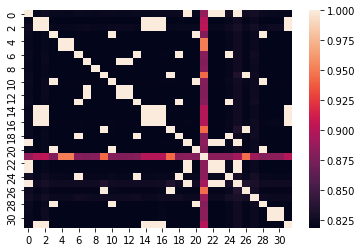

In [26]:
rbf_test = getLayerOutput(model = teacher,data = x_train[0:batch_size], layer_idx = -1, softmaxed= False)
rbf = rbf_kernel(rbf_test)
sns.heatmap(rbf)

<AxesSubplot:>

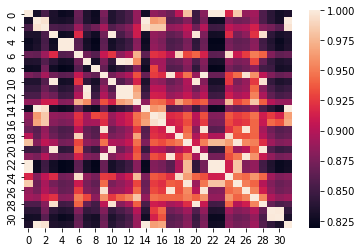

In [27]:
rbf_test_s = getLayerOutput(model = distilled,data = x_train[0:batch_size], layer_idx = -1, softmaxed= False)
rbf_s = rbf_kernel(rbf_test_s)
sns.heatmap(rbf_s)

<AxesSubplot:>

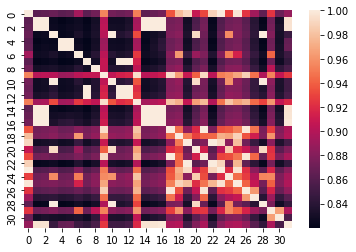

In [45]:
rbf_test_r = getLayerOutput(model = r_distilled,data = x_train[0:batch_size], layer_idx = -1, softmaxed= False)
rbf_r = rbf_kernel(rbf_test_r)
sns.heatmap(rbf_r)

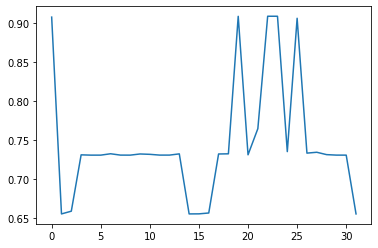

In [29]:
taylored_t = pOrderTaylor(rbf,order=2)
pyplot.plot(taylored_t)

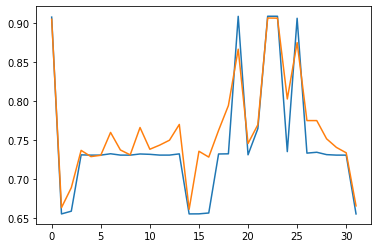

In [57]:
taylored_s = pOrderTaylor(rbf_s,order=2)
pyplot.plot(taylored_t)
pyplot.plot(taylored_s)

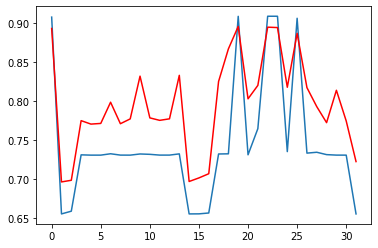

In [58]:
taylored_r = pOrderTaylor(rbf_r,order=2)
pyplot.plot(taylored_t)
pyplot.plot(taylored_r, color='red')

In [32]:
print(sum(abs(taylored_t - taylored_s)),sum(abs(taylored_t - taylored_r)))

0.7322705239057541 3.5317481234669685


In [33]:
corrCongruence(rbf_test,rbf_test_s)

0.7322705239057541

In [34]:
# Train student as done usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.TopKCategoricalAccuracy(k=top_k)],
)

In [35]:
# Train and evaluate student trained from scratch.
scratch_history = student_scratch.fit(x_train, y_train, epochs= nb_epochs, validation_data=(x_test,y_test))
scratch_evaluation = student_scratch.evaluate(x_test, y_test, return_dict=True)

Epoch 1/50
1563/1563 [==============================] - 12s 7ms/step - loss: 2.0795 - sparse_categorical_accuracy: 0.2040 - top_k_categorical_accuracy: 0.2329 - val_loss: 1.8148 - val_sparse_categorical_accuracy: 0.2877 - val_top_k_categorical_accuracy: 0.2103
Epoch 2/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8802 - sparse_categorical_accuracy: 0.2567 - top_k_categorical_accuracy: 0.2045 - val_loss: 1.7235 - val_sparse_categorical_accuracy: 0.3201 - val_top_k_categorical_accuracy: 0.2517
Epoch 3/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8312 - sparse_categorical_accuracy: 0.2732 - top_k_categorical_accuracy: 0.2127 - val_loss: 1.6756 - val_sparse_categorical_accuracy: 0.3369 - val_top_k_categorical_accuracy: 0.2875
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8066 - sparse_categorical_accuracy: 0.2846 - top_k_categorical_accuracy: 0.2220 - val_loss: 1.6331 - val_sparse_categorical_accuracy: 0.34

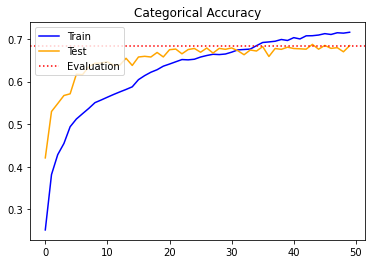

In [36]:
distilAccuracies(d_history)

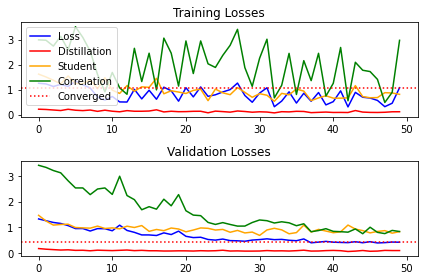

In [47]:
distilLosses(d_history)

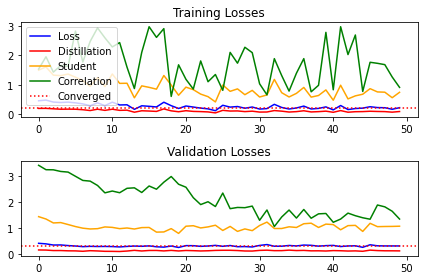

In [48]:
distilLosses(r_history)

In [39]:
r_history.keys()

dict_keys(['Loss', 'DistilLoss', 'StudentLoss', 'Correlation Congruence', 'categorical_accuracy', 'Distillation_categorical_accuracy', 'Val_loss', 'Val_distilLoss', 'Val_studentLoss', 'Val_Correlation Congruence', 'Val_categorical_accuracy', 'Val_distillation_categorical_accuracy'])

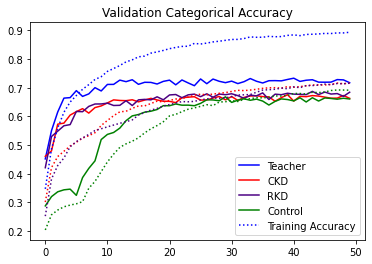

In [49]:
pyplot.title('Validation Categorical Accuracy')
pyplot.plot(teacher_history.history['val_sparse_categorical_accuracy'], color='blue', label='teacher')
pyplot.plot(r_history['Val_categorical_accuracy'], color='red', label='ckd')
pyplot.plot(d_history['Val_categorical_accuracy'], color='indigo', label='rkd')
pyplot.plot(scratch_history.history['val_sparse_categorical_accuracy'], color='green', label='scratch')

pyplot.plot(teacher_history.history['sparse_categorical_accuracy'], color='blue', label='tr_teacher', ls = 'dotted')
pyplot.plot(r_history['categorical_accuracy'], color='red', label='tr_ckd', ls = 'dotted')
pyplot.plot(d_history['categorical_accuracy'], color='indigo', label='tr_rkd', ls = 'dotted')
pyplot.plot(scratch_history.history['sparse_categorical_accuracy'], color='green', label='tr_scratch', ls = 'dotted')

pyplot.legend(['Teacher','CKD','RKD','Control','Training Accuracy'], loc= 'lower right')
pyplot.show()

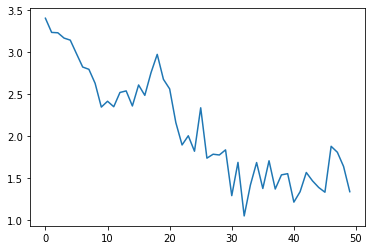

In [50]:
pyplot.plot(r_history['Val_Correlation Congruence'])